# Building Models in PyMC3

Bayesian inference begins with specification of a probability model relating unknown variables to data. PyMC3 provides the basic building blocks for Bayesian probability models: stochastic random variables, deterministic variables, and factor potentials. 

A **stochastic random variable** is a factor whose value is not completely determined by its parents, while the value of a **deterministic random variable** is entirely determined by its parents. Most models can be constructed using only these two variable types. The third quantity, the **factor potential**, is *not* a variable but simply a
log-likelihood term or constraint that is added to the joint log-probability to modify it. 

## The FreeRV class

A stochastic variable is represented in PyMC3 by a `FreeRV` class. This structure adds functionality to Theano's `TensorVariable` class, by mixing in the PyMC `Factor` class. A `Factor` is used whenever a variable contributes a log-probability term to a model. Hence, you know a variable is a subclass of `Factor` whenever it has a `logp` method, as we saw in the previous section.

A `FreeRV` object has several important attributes:

`dshape`
:   The variable's shape.

`dsize`
:   The overall size of the variable.

`distribution`
:   The probability density or mass function that describes the distribution of the variable's values.

`logp`
:   The log-probability of the variable's current value given the values
    of its parents.

`init_value`
:   The initial value of the variable, used by many algorithms as a starting point for model fitting.

`model`
:   The PyMC model to which the variable belongs.


### Creation of stochastic random variables

There are two ways to create stochastic random variables (`FreeRV` objects), which we will call the **automatic**, and **manual** interfaces.

#### Automatic

Stochastic random variables with standard distributions provided by PyMC3 can be created in a single line using special subclasses of the `Distribution` class. For example, as we have seen, the uniformly-distributed discrete variable $switchpoint$ in the coal mining disasters model is created using the automatic interface as follows:

In [1]:
import pymc3 as pm

with pm.Model() as disaster_model:

    switchpoint = pm.DiscreteUniform('switchpoint', lower=0, upper=110)

Similarly, the rate parameters can automatically be given exponential priors:

In [2]:
with disaster_model:
    early_mean = pm.Exponential('early_mean', lam=1)
    late_mean = pm.Exponential('late_mean', lam=1)

PyMC includes most of the probability density functions (for continuous variables) and probability mass functions (for discrete variables) used in statistical modeling. Continuous variables are represented by a specialized subclass of `Distribution` called `Continuous` and discrete variables by the `Discrete` subclass.

The main differences between these two sublcasses are in the `dtype` attribute (`int64` for `Discrete` and `float64` for `Continuous`) and the `defaults` attribute, which determines which summary statistic to use for initial values when one is not specified ('mode' for `Discrete` and 'median', 'mean', and 'mode' for `Continuous`).

In [3]:
switchpoint.distribution.defaults

('mode',)

As we previewed in the introduction, `Distribution` has a class method `dist` that returns a probability distribution of that type, without being wrapped in a PyMC random variable object. Sometimes we wish to use a particular statistical distribution, without using it as a variable in a model; for example, to generate random numbers from the distribution. This class method allows that.

In [4]:
pm.Exponential.dist(1)

#### Manual

The uniformly-distributed discrete stochastic variable `switchpoint` in the disasters model could alternatively be created from a function that computes its log-probability as follows:

In [5]:
import theano.tensor as tt

In [6]:
import numpy as np
from pymc3.math import switch, log

with pm.Model():  

    
    def uniform_logp(value, lower=0, upper=111):
        """The switchpoint for the rate of disaster occurrence."""
        return switch((value > upper) | (value < lower), -np.inf, -log(upper - lower + 1))

    switchpoint = pm.DensityDist('switchpoint', logp=uniform_logp, dtype='int64')

In [7]:
switchpoint.logp({'switchpoint':4})

array(-4.7184987, dtype=float32)

In [8]:
switchpoint.logp({'switchpoint': 44})

array(-4.7184987, dtype=float32)

In [9]:
switchpoint.logp({'switchpoint':-1})

array(-inf, dtype=float32)

A couple of things to notice: while the function specified for the `logp` argument can be an arbitrary Python function, it must use **Theano operators and functions** in its body. This is because one or more of the arguments passed to the function may be `TensorVariables`, and they must be supported. Also, we passed the value to be evaluated by the `logp` function as a **dictionary**, rather than as a plain integer. By convention, values in PyMC3 are passed around as a data structure called a `Point`. Points in parameter space are represented by dictionaries with parameter names as they keys and the value of the parameters as the values.

To emphasize, the Python function passed to `DensityDist` should compute the *log*-density or *log*-probability of the variable. That is why the return value in the example above is `-log(upper-lower+1)` rather than `1/(upper-lower+1)`.

### Specifying Custom Distributions

Similarly, the library of statistical distributions in PyMC3 is not exhaustive, but PyMC allows for the creation of user-defined functions for an **arbitrary probability distribution**. For simple statistical distributions, the `DensityDist` function takes as an argument any function that calculates a log-probability $log(p(x))$. This function may employ other random variables in its calculation. 


Here is a simple example inspired by a blog post by Jake Vanderplas (Vanderplas, 2014), where Jeffreys priors are used to specify priors that are invariant to transformation. In the case of simple linear regression, these are:

$$\beta \propto (1+\beta^2)^{3/2}$$

$$\sigma \propto \frac{1}{\alpha}$$

The logarithms of these functions can be specified as the argument to DensityDist and inserted into the model.

```python
import theano.tensor as T
from pymc3 import DensityDist, Uniform

with Model() as model:
    alpha = Uniform('intercept', -100, 100)
    
    # Create custom densities
    beta = DensityDist('beta', lambda value: -1.5 * T.log(1 + value**2), testval=0)
    eps = DensityDist('eps', lambda value: -T.log(T.abs_(value)), testval=1)
    
    # Create likelihood
    like = Normal('y_est', mu=alpha + beta * X, sd=eps, observed=Y)
```

For more complex distributions, one can create a subclass of `Continuous` or `Discrete` and provide the custom `logp` function, as required. This is how the built-in distributions in PyMC are specified. As an example, fields like psychology and astrophysics have complex likelihood functions for a particular process that may require numerical approximation. In these cases, it is impossible to write the function in terms of predefined theano operators and we must use a custom theano operator using `as_op` or inheriting from `theano.Op`. 

Implementing the `beta` variable above as a `Continuous` subclass is shown below, along with a sub-function using the `as_op` decorator, though this is not strictly necessary.

In [10]:
from pymc3.distributions import Continuous
import theano.tensor as tt
from theano import as_op

class Beta(Continuous):
    def __init__(self, mu, *args, **kwargs):
        super(Beta, self).__init__(*args, **kwargs)
        self.mu = mu
        self.mode = mu

    def logp(self, value):
        mu = self.mu
        return beta_logp(value - mu)
    
@as_op(itypes=[tt.dscalar], otypes=[tt.dscalar])
def beta_logp(value):
    return -1.5 * np.log(1 + (value)**2)


with pm.Model() as model:
    beta = Beta('slope', mu=0, testval=0)

## The ObservedRV Class

Stochastic random variables whose values are observed (*i.e.* data likelihoods) are represented by a different class than unobserved random variables. A `ObservedRV` object is instantiated any time a stochastic variable is specified with data passed as the `observed` argument. 

Otherwise, observed stochastic random variables are created via the same interfaces as unobserved: **automatic** or **manual**. As an example of an automatic instantiation, consider a Poisson data likelihood :

In [11]:
with disaster_model:
    
    disasters = pm.Poisson('disasters', mu=3, observed=[3,4,1,2,0,2,2])

We have already seen manual instantiation, from the melanoma survial model where the exponential survival likelihood was implemented manually:

```python
def logp(failure, value):
    return (failure * log(lam) - lam * value).sum()

x = DensityDist('x', logp, observed={'failure':failure, 'value':t})
```

Notice in this example that there are two vetors observed data for the likelihood `x`, passed as a dictionary.

An important responsibility of `ObservedRV` is to automatically handle missing values in the data, when they are present (absent?). More on this later.

## Deterministic Variables

A deterministic variable is one whose values are **completely determined** by the values of their parents. For example, in our disasters model, `rate` is a deterministic variable.

In [12]:
with disaster_model:
    
    rate = pm.Deterministic('rate', switch(switchpoint >= np.arange(112), early_mean, late_mean))

so `rate`'s value can be computed exactly from the values of its parents `early_mean`, `late_mean` and `switchpoint`.

There are two types of deterministic variables in PyMC3

#### Anonymous deterministic variables

The easiest way to create a deterministic variable is to operate on or transform one or more variables in a model directly. For example, the simplest way to specify the `rate` variable above is as follows:

In [13]:
with disaster_model:
    
    rate = switch(switchpoint >= np.arange(112), early_mean, late_mean)

Or, let's say we wanted to use the mean of the `early_mean` and `late_mean` variables somehere in our model:

In [14]:
with disaster_model:
    
    diff_means = pm.Deterministic('diff_means', early_mean - late_mean)

These are called *anonymous* variables because we did not wrap it with a call to `Determinstic`, which gives it a name as its first argument. We simply specified the variable as a Python (or, Theano) expression. This is therefore the simplest way to construct a determinstic variable. The only caveat is that the values generated by anonymous determinstics at every iteration of a MCMC algorithm, for example, are not recorded to the resulting trace. So, this approach is only appropriate for intermediate values in your model that you do not wish to obtain posterior estimates for, alongside the other variables in the model.

#### Named deterministic variables

To ensure that deterministic variables' values are accumulated during sampling, they should be instantiated using the **named deterministic** interface; this uses the `Deterministic` function to create the variable. Two things happen when a variable is created this way:

1. The variable is given a name (passed as the first argument)
2. The variable is appended to the model's list of random variables, which ensures that its values are tallied.


```python
with disaster_model:
    
    rate = pm.Deterministic('rate', switch(switchpoint >= np.arange(112), early_mean, late_mean))
```

In [15]:
disaster_model.named_vars

{'switchpoint': switchpoint,
 'early_mean_log__': early_mean_log__,
 'early_mean': early_mean,
 'late_mean_log__': late_mean_log__,
 'late_mean': late_mean,
 'disasters': disasters,
 'rate': rate,
 'diff_means': diff_means}

## Factor Potentials

For some applications, we want to be able to modify the joint density by incorporating terms that don't correspond to probabilities of variables conditional on parents, for example:

$$p(x_0, x_2, \ldots x_{N-1}) \propto \prod_{i=0}^{N-2} \psi_i(x_i, x_{i+1})$$

In other cases we may want to add probability terms to existing models. For example, suppose we want to constrain the difference between the early and late means in the disaster model to be less than 1, so that the joint density becomes: 

$$p(y,\tau,\lambda_1,\lambda_2) \propto p(y|\tau,\lambda_1,\lambda_2) p(\tau) p(\lambda_1) p(\lambda_2) I(|\lambda_2-\lambda_1| \lt 1)$$

We call such log-probability terms **factor potentials** (Jordan 2004). Bayesian
hierarchical notation doesn't accomodate these potentials. 

### Creation of Potentials

A potential can be created via the `Potential` function, in a way very similar to `Deterministic`'s named interface:

In [16]:
with disaster_model:
    
    rate_constraint = pm.Potential('rate_constraint', 
                                   switch(pm.math.abs_(early_mean-late_mean)>1, -np.inf, 0))

The function takes just a `name` as its first argument and an expression returning the appropriate log-probability as the second argument.

A common use of a factor potential is to represent an observed likelihood, where the **observations are partly a function of model variables**. In the contrived example below, we are representing the error in a linear regression model as a zero-mean normal random variable. Thus, the "data" in this scenario is the residual, which is a function both of the data and the regression parameters. 

In [17]:
y = np.array([15, 10, 16, 11, 9, 11, 10, 18, 11])
x = np.array([1, 2, 4, 5, 6, 8, 19, 18, 12])

with pm.Model() as arma_model:

    sigma = pm.HalfCauchy('sigma', 5)
    beta = pm.Normal('beta', 0, sd=2)
    mu = pm.Normal('mu', 0, sd=10)

    err = y - (mu + beta*x)
                  
    like = pm.Potential('like', pm.Normal.dist(0, sd=sigma).logp(err))

This parameterization would not be compatible with an observed stochastic, because the `err` term would become fixed in the likelihood and not be allowed to change during sampling.

## Sampling with MCMC

PyMC's core business is using Markov chain Monte Carlo to fit virtually any probability model. This involves the assignment and coordination of a suite of **step methods**, each of which is responsible for updating one or more variables. 

The user's interface to PyMC's sampling algorithms is the `sample` function:

```python
sample(draws, step=None, start=None, trace=None, chains=0, cores=1, tune=None, 
        progressbar=True, model=None, random_seed=None)
```

`sample` assigns particular samplers to model variables, and generates samples from them. The `draws` argument
controls the total number of MCMC iterations. PyMC can automate most of the details of sampling, outside of the selection of the number of draws, using default settings for several parameters that control how the sampling is set up and conducted. However, users may manually intervene in the specification of the sampling by passing values to a number of keyword argumetns for `sample`.

### Assigning step methods

The `step` argument allows users to assign a MCMC sampling algorithm to the entire model, or to a subset of the variables in the model. For example, if we wanted to use the Metropolis-Hastings sampler to fit our model, we could pass an instance of that step method to `sample` via the `step` argument:

```python
with my_model:

    trace = sample(1000, step=Metropolis())
```

or if we only wanted to assign `Metropolis` to a parameter called `β`:

```python
with my_model:

    trace = sample(1000, step=Metropolis(vars=[β]))
```

When `step` is not specified by the user, PyMC3 will assign step methods to variables automatically. To do so, each step method implements a class method called `competence`. This method returns a value from 0 (incompatible) to 3 (ideal), based on the attributes of the random variable in question. `sample` assigns the step method that returns the highest competence value to each of its unallocated stochastic random variables. In general:

* Binary variables will be assigned to `BinaryMetropolis` (Metropolis-Hastings for binary values)
* Discrete variables will be assigned to `Metropolis`
* Continuous variables will be assigned to `NUTS` (No U-turn Sampler)

### Starting values

The `start` argument allows for the specification of starting values for stochastic random variables in the model. MCMC algorithms begin by initializing all unknown quantities to arbitrary starting values. Though in theory the value can be any value under the support of the distribution describing the random variable, we can make sampling more difficult if an initial value is chosen in the extreme tail of the distribution, for example. 

In [18]:
from pymc3.examples.gelman_bioassay import model as bioassay_model

with bioassay_model:
    trace = pm.sample(100, step=pm.Metropolis(), start={'alpha': 0.1, 'beta': -1})

Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 2 chains: 100%|██████████| 1200/1200 [00:00<00:00, 3174.06draws/s]
The number of effective samples is smaller than 25% for some parameters.


If starting values are not passed by the user, default values are chosen from the mean, median or mode of the distribution.

It is possible to choose starting values using an optimization procedure. For example, one may initialize a MCMC simulation at the maximum *a posteriori* (MAP) estimate (though it is not recommended!):

In [19]:
with bioassay_model:
    
    trace = pm.sample(100, step=pm.Metropolis(), init='map')

Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 2 chains: 100%|██████████| 1200/1200 [00:00<00:00, 2973.73draws/s]
The number of effective samples is smaller than 25% for some parameters.


There are several different values that can be passed as the `init` argument: 

* `adapt-diag`: Start with a identity mass matrix and then adapt a diagonal based on the variance of the tuning samples. All chains use the default test value as starting point.
* `jitter+adapt_diag`: Same as `adapt_diag`, but add uniform random noise in (-1, 1) to the starting point in each chain.
* `advi+adapt_diag`: Run ADVI and then adapt the resulting diagonal mass matrix based on the sample variance of the tuning samples.
* `advi+adapt_diag_grad`: Run ADVI and then adapt the resulting diagonal mass matrix based on the variance of the gradients during tuning. This is **experimental** and might be removed in a future release.
* `advi`: Run ADVI to estimate posterior mean and diagonal mass matrix.
* `advi_map`: Initialize ADVI with MAP; use MAP as starting point and the resulting standard deviations from ADVI to create a scaling matrix for NUTS.
* `map`: Use MAP estimate as starting point.
* `nuts`: Run NUTS to estimate starting points and covariance matrix.
* `None`: Use default values (typically mean, median or mode) as starting point.

If we are sampling more than one Markov chain from our model, it is often recommended to initialize each chain to different starting values, so that lack of convergence can be more easily detected (see *Model Checking* section). 

### Storing samples

Notice in the above call to `sample` that output is assigned to a variable we have called `trace`. 

In [20]:
trace

<MultiTrace: 2 chains, 100 iterations, 3 variables>

This `MultiTrace` object is a data structure that stores the samples from an MCMC run in a tabular structure. By default, `sample` will create a new `MultiTrace` object that stores its samples in memory, as a NumPy `ndarray`. We can override the default behavior by specifying the `trace` argument. There are three options:

1. Selecting an alternative database backend to keeping samples in an `ndarray`. Passing either "text" or "sqlite", for example, will save samples to text files or a SQLite database, respectively. An instance of a backend can also be passed.
2. Passing a list of variables will only record samples for the subset of variables specified in the list. These will be stored in memory.
3. An existing `MultiTrace` object. This will add samples to an existing backend.


In [21]:
with bioassay_model:
    db_trace = pm.sample(100, init=None, trace='text')

Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 1200/1200 [00:01<00:00, 1103.71draws/s]


In [22]:
ls mcmc

chain-0.csv  chain-1.csv


We will look at the various database backends in greater detail in the next section.

### Parallel sampling

Nearly all modern desktop computers have multiple CPU cores, and running multiple MCMC chains is an **embarrasingly parallel** computing task. It is therefore relatively simple to run chains in parallel in PyMC3. This is done by setting the `chains` argument in `sample` to some value between 2 and the number of cores on your machine. The default value of `chains` is 2.
    
Note that the number of chains you want to sample and the number of cores used to get them are two separate issues. You can set the number of CPUs separately from the number of chains by specifying the `cores` argument accordingly. The default value is the number of cores available on your machine or 4, whichever is smaller.

In [23]:
with bioassay_model:
    ptrace = pm.sample(100, init=None, chains=4)

Only 100 samples in chain.
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 4 chains: 100%|██████████| 2400/2400 [00:02<00:00, 1174.79draws/s]


Running $n$ iterations with $c$ chains will result in $n \times c$ samples.

In [24]:
ptrace['alpha'].shape

(400,)

If you want to specify different arguments for each chain, a list of argument values can be passed to `sample` as appropriate. For example, if we want to initialize random variables to particular (*e.g.* dispersed) values, we can pass a list of dictionaries to `start`:

In [25]:
with bioassay_model:
    ptrace = pm.sample(100, chains=2, init=None, start=[{'alpha':-2}, {'alpha':2}])

Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 1200/1200 [00:01<00:00, 992.00draws/s] 


In [26]:
[chain[:5] for chain in ptrace.get_values('alpha', combine=False)]

[array([-0.77969113, -0.67630323, -0.81695138, -1.0119219 ,  0.31077703]),
 array([-0.49186018,  0.56096367, -0.17292688,  0.41286299, -0.41047506])]

Generating several chains is generally recommended because it aids in model checking, allowing statistics such as the potential scale reduction factor ($\hat{R}$) and effective sample size to be calculated.

### Reproducible sampling

A practical drawback of using stochastic sampling methods for statistical inference is that it can be more difficult to reproduce individual results, due to the fact that sampling involves the use of pseudo-random number generation. To aid in reproducibility (and debugging), it can be helpful to set a **random number seed** prior to sampling. The `random_seed` argument can be used to set PyMC's random number generator to a particular seed integer, which results in the same sequence of random numbers each time the seed is set to the same value.

In [27]:
with bioassay_model:
    rtrace = pm.sample(100, init=None, random_seed=42)

Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 1200/1200 [00:01<00:00, 1122.85draws/s]


In [28]:
rtrace['beta', -5:]

array([1.47108509, 0.65930403, 0.95529056, 2.5817714 , 1.2114086 ,
       2.07363518, 1.79273471, 2.9903187 , 3.92953886, 0.84603328])

Setting the same seed for another run of the same model will generate the same sequence of samples:

In [29]:
with bioassay_model:
    rtrace = pm.sample(100, init=None, random_seed=42)

Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 1200/1200 [00:00<00:00, 1316.84draws/s]


In [30]:
rtrace['beta', -5:]

array([1.47108509, 0.65930403, 0.95529056, 2.5817714 , 1.2114086 ,
       2.07363518, 1.79273471, 2.9903187 , 3.92953886, 0.84603328])

## Step methods

Step method classes handle individual stochastic variables, or sometimes groups of them. They are responsible for making the variables they handle take **single MCMC steps** conditional on the rest of the model. Each PyMC step method (usually subclasses of `ArrayStep`) implements a method called `astep()`, which is called iteratively by `sample`. 

All step methods share an optional argument `vars` that allows a particular subset of variables to be handled by the step method instance. Particular step methods will have additional arguments for setting parameters and preferences specific to that sampling algorithm.

> NB: when a PyMC function or method has an argument called `vars` it is expecting a list of variables (*i.e.* the variables themselves), whereas arguments called `varnames` expect a list of variables names (*i.e.* strings)

### HamiltonianMC

The Hamiltonian Monte Carlo algorithm is implemented in the `HamiltonianMC` class. Being a gradient-based sampler, it is only suitable for **continuous random variables**. Several optional arguments can be provided by the user. The algorithm is **non-adaptive**, so the parameter values passed at instantiation are fixed at those values throughout sampling.

`HamiltonianMC` requires a scaling matrix parameter `scaling`, which is analogous to the variance parameter for the jump proposal distribution in Metropolis-Hastings, although it is used somewhat differently here. The matrix gives an approximate shape of the posterior distribution, so that `HamiltonianMC` does not make jumps that are too large in some directions and too small in other directions. It is important to set this scaling parameter to a reasonable value to facilitate efficient sampling. This is especially true for models that have many unobserved stochastic random variables or models with highly non-normal posterior distributions. 

Fortunately, `HamiltonianMC` can often make good guesses for the scaling parameters. If you pass a point in parameter space (as a dictionary of variable names to parameter values, the same format as returned by `find_MAP`), it will look at the **local curvature** of the log posterior-density (the diagonal of the Hessian matrix) at that point to guess values for a good scaling vector, which can result in a good scaling value. Also, the MAP estimate is often a good point to use to initiate sampling. 

- `scaling` 
: Scaling for momentum distribution. If a 1-dimensional array is passed, it is interpreted as a matrix diagonal.
            
- `step_scale` 
: Size of steps to take, automatically scaled down by $1/n^{0.25}$. Defaults to .25.
            
- `path_length` 
: total length to travel during leapfrog. Defaults to 2.
            
- `is_cov` 
: Flag for treating scaling as a covariance matrix/vector, if True. Treated as precision otherwise.
            
- `step_rand` 
: A function which takes the step size and returns an new one used to randomize the step size at each iteration.


### NUTS

`NUTS` is the No U-turn Sampler of Hoffman and Gelman (2014), an adaptive version of Hamiltonian MC that **automatically tunes** the step size and number on the fly. 

In addition to the arguments to `HamiltonianMC`, `NUTS` takes additional parameters to controls the tuning. The most important of these is the target acceptance rate for the Metropolis acceptance phase of the algorithm, `taget_accept`. 
Sometimes if the NUTS struggles to sample efficiently, changing this parameter above the default target rate of 0.8 will improve sampling (the original recommendation by Hoffman & Gelman was 0.6). Increasing the rate very high will also make the sampler more conservative, however, taking many small steps at every iteration. 


In [31]:
with bioassay_model:
    trace_60 = pm.sample(100, step=pm.NUTS(target_accept=0.6), init=None)

Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 1200/1200 [00:01<00:00, 970.28draws/s]
The acceptance probability does not match the target. It is 0.7019939774054694, but should be close to 0.6. Try to increase the number of tuning steps.


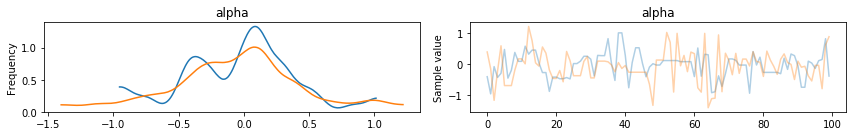

In [32]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

pm.traceplot(trace_60, varnames=['alpha']);

In [33]:
with bioassay_model:
    trace_9999 = pm.sample(100, step=pm.NUTS(target_accept=0.9999), init=None)

Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 1200/1200 [00:03<00:00, 352.20draws/s]
The acceptance probability does not match the target. It is 0.9960793804544853, but should be close to 0.9999. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.997328035336595, but should be close to 0.9999. Try to increase the number of tuning steps.


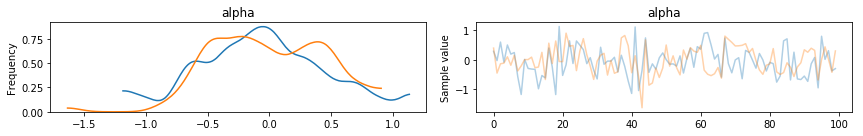

In [34]:
pm.traceplot(trace_9999, varnames=['alpha']);

There is rarely a reason to use `HamiltonianMC` rather than `NUTS`. It is the default sampler for continuous variables in PyMC3.

### Metropolis

``Metropolis`` implements a Metropolis-Hastings step, as described the theory section, and is designed to handle float- and integer-valued variables.

A `Metropolis` step method can be instantiated with any of several optional arguments. Important ones include:


- `S`
:   This sets the proposal standard deviation or covariance matrix.

- `proposal_dist`
:   A function that generates zero-mean random deviates used as proposals. Defaults to the normal distribution.

- `scaling`
:   An initial scale factor for the proposal

- `tune_interval`
:   The number of intervals between tuning updates to `scaling` factor.

When the step method is instantiated, the `proposal_dist` is parameterized with the value passed for `S`. While sampling, the value of `scaling` is used to scale the value proposed by `proposal_dist`, and this value is tuned throughout the MCMC run. During tuning, the acceptance ratio of the step method is examined, and this scaling factor
is updated accordingly. Tuning only occurs when the acceptance rate is **lower than 20%** or **higher than 50%**; rates between 20-50% are considered optimal for Metropolis-Hastings sampling. The default tuning interval (`tune_interval`) is 100 iterations.

Although tuning will continue throughout the sampling loop, it is important to verify that the
**diminishing tuning** condition of [Roberts and Rosenthal (2007)](http://projecteuclid.org/DPubS?service=UI&version=1.0&verb=Display&handle=euclid.jap/1183667414) is satisfied: the
amount of tuning should decrease to zero, or tuning should become very infrequent.

`Metropolis` handles discrete variable types automatically by rounding the proposed values and casting them to integers.

### BinaryMetropolis

While binary (boolean) variables can be handled by the `Metropolis` step method, sampling will be very inefficient. The `BinaryMetropolis` class is optimized to handle binary variables, by one of only two possible values. The only tuneable parameter is the `scaling` argument, which is used to vary the Bernoulli probability:

    p_jump = 1. - .5 ** self.scaling

This value is compared to pseudo-random numbers generated by the step method, to determine whether a 0 or 1 is proposed.

`BinaryMetropolis` will be automatically selected for random variables that are distributed as Bernoulli, or categorical with only 2 categories.

### Slice

Though the Metropolis-Hastings algorithm is easy to implement for a variety of models, its efficiency is poor. We have seen that it is possible to tune Metropolis samplers, but it would be nice to have a "black-box" method that works for arbitrary continuous distributions, which we may know little about a priori.

The **slice sampler** (Neal 2003) improves upon the Metropolis sampler by being both efficient and easy to program generally. The idea is to first sample from the conditional distribution for $y$ (i.e., $Pr(x)$) given some current value of $x$, which is uniform over the $(0,f(x))$, and conditional on this value for $y$, then sample $x$, which is uniform on $S = {x : y < f (x)}$.

The steps required to perform a single iteration of the slice sampler to update the current value of $x_i$ is as follows:

1. Sample $y$ uniformly on (0,f(xi)).
2. Use this value $y$ to define a horizontal *slice* $S = {x : y < f (x)}$.
3. Establish an interval, I=(xa,xb), around xi that contains most of the slice.
4. Sample $x_{i+1}$ from the region of the slice overlaping I.

Hence, slice sampling employs an **auxilliary variable** ($y$) that is not retained at the end of the iteration. Note that in practice one may operate on the log scale such that $g(x) = \log(f (x))$ to avoid floating-point underflow. In this case, the auxiliary variable becomes $z = log(y) = g(x_i) − e$, where $e \sim \text{Exp}(1)$, resulting in the slice $S = \{x : z < g(x)\}$.

There are many ways of establishing and sampling from the interval $I$, with the only restriction being that the resulting Markov chain leaves $f(x)$ **invariant**. The objective is to include as much of the slice as possible, so that the potential step size can be large, but not (much) larger than the slice, so that the sampling of invalid points is minimized. Ideally, we would like it to be the slice itself, but it may not always be feasible to determine (and certainly not automatically).

In PyMC3, the `Slice` class implements the **univariate** slice sampler. It is suitable for univariate, continuous variables. There is a single user-defined parameter `w`, which sets the width of the initial slice. If not specified, it defaults to a width of 1.

In [35]:
with bioassay_model:
    
    slice_trace = pm.sample(5000, step=pm.Slice())

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [beta]
>Slice: [alpha]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:13<00:00, 836.32draws/s]


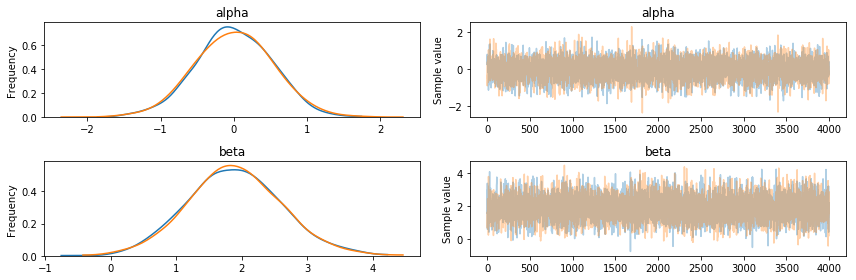

In [36]:
pm.traceplot(slice_trace[1000:], varnames=['alpha','beta']);

PyMC3 also includes implementations of:

- Sequential Monte Carlo (SMC): also known as adaptive transitional Markov chain Monte Carlo (ATMCMC, Ching & Chen 2007) 
- Stochastic Gradient MCMC
- Elliptical Slice Sampling

which we will not cover here. Consult the [documentation](https://pymc-devs.github.io/pymc3/api.html?highlight=atmcmc#module-pymc3.step_methods.ATMCMC) for details.

## Imputation of Missing Data

As with most textbook examples, the models we have examined so far assume that the associated data are complete. That is, there are no **missing values** corresponding to any observations in the dataset. However, many real-world datasets have missing observations, usually due to some logistical problem during the data collection process. The easiest way of dealing with observations that contain missing values is simply to exclude them from the analysis. However, this results in loss of information if an excluded observation contains valid values for other quantities, and can bias results. An alternative is to impute the missing values, based on information in the rest of the model.

For example, consider a survey dataset for some wildlife species:

    Count   Site   Observer   Temperature
    ------- ------ ---------- -------------
    15      1      1          15
    10      1      2          NA
    6       1      1          11

Each row contains the number of individuals seen during the survey, along with three covariates: the site on which the survey was conducted, the observer that collected the data, and the temperature during the survey. If we are interested in modelling, say, population size as a function of the count and the associated covariates, it is difficult to accommodate the second observation because the temperature is missing (perhaps the thermometer was broken that day). Ignoring this observation will allow us to fit the model, but it wastes information that is contained in the other covariates.

In a Bayesian modelling framework, missing data are accommodated simply by treating them as **unknown model parameters**. Values for the missing data $\tilde{y}$ are estimated naturally, using the posterior predictive distribution:

$$p(\tilde{y}|y) = \int p(\tilde{y}|\theta) f(\theta|y) d\theta$$

This describes additional data $\tilde{y}$, which may either be considered unobserved data or potential future observations. We can use the posterior predictive distribution to model the likely values of missing data.

Consider the coal mining disasters data introduced previously. Assume that two years of data are missing from the time series; we indicate this in the data array by the use of an arbitrary placeholder value, `None`:

In [37]:
disasters_missing = np.array([ 4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

To estimate these values in PyMC, we cast the data to a **masked array**. These are specialised NumPy arrays that contain a matching True or False value for each element to indicate if that value should be excluded from any computation. Masked arrays can be generated using NumPy's `ma.masked_equal` function:

In [38]:
disasters_masked = np.ma.masked_values(disasters_missing, value=-999)
disasters_masked

masked_array(data=[4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6, 3, 3,
                   5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5, 2, 2, 3, 4,
                   2, 1, 3, --, 2, 1, 1, 1, 1, 3, 0, 0, 1, 0, 1, 1, 0, 0,
                   3, 1, 0, 3, 2, 2, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 2,
                   1, 0, 0, 0, 1, 1, 0, 2, 3, 3, 1, --, 2, 1, 1, 1, 1, 2,
                   4, 2, 0, 0, 1, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
                   1, 0, 1],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False,  True,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
      

This masked array, in turn, can then be passed to one of PyMC's data stochastic variables, which recognizes the masked array and replaces the missing values with stochastic variables of the desired type. For the coal mining disasters problem, recall that disaster events were modeled as Poisson variates:

```python
disasters = Poisson('disasters', mu=rate, observed=masked_values)
```

Each element in `disasters` is a Poisson random variable, irrespective of whether the observation was missing or not. The difference is that actual observations are assumed to be data stochastics, while the missing
values are unobserved stochastics. The latter are considered unknown, rather than fixed, and therefore estimated by the fitting algorithm, just as unknown model parameters are.

The entire model looks very similar to the original model:

In [39]:
with pm.Model() as missing_data_model:

    # Prior for distribution of switchpoint location
    switchpoint = pm.DiscreteUniform('switchpoint', lower=0, upper=len(disasters_masked))
    # Priors for pre- and post-switch mean number of disasters
    early_mean = pm.Exponential('early_mean', lam=1.)
    late_mean = pm.Exponential('late_mean', lam=1.)

    # Allocate appropriate Poisson rates to years before and after current
    # switchpoint location
    idx = np.arange(len(disasters_masked))
    rate = pm.Deterministic('rate', switch(switchpoint >= idx, early_mean, late_mean))

    # Data likelihood
    disasters = pm.Poisson('disasters', rate, observed=disasters_masked)

Here, we have used the `masked_array` function, rather than
`masked_equal`, and the value -999 as a placeholder for missing data.
The result is the same.

In [40]:
with missing_data_model:
    trace_missing = pm.sample(10000, step=pm.Metropolis())

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [disasters_missing]
>Metropolis: [late_mean]
>Metropolis: [early_mean]
>Metropolis: [switchpoint]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:30<00:00, 689.72draws/s]
The number of effective samples is smaller than 10% for some parameters.


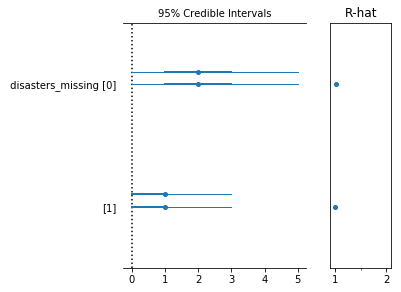

In [41]:
from pymc3 import forestplot

pm.forestplot(trace_missing[1000:], varnames=['disasters_missing'])

# Generalized Linear Models

Generalized Linear Models (GLMs) are a class of flexible models that are widely used to estimate regression relationships between a single outcome variable and one or multiple predictors. Because these models are so common, `PyMC3` offers a `glm` submodule that allows flexible creation of various GLMs with an intuitive **`R`-like syntax** that is implemented via the `patsy` module.

The `glm` submodule requires data to be included as a `pandas` `DataFrame`. Hence, for our linear regression example:

In [42]:
import pandas as pd

# Generate data
size = 50
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
y = true_intercept + x*true_slope + np.random.normal(scale=.5, size=size)

data = pd.DataFrame(dict(x=x, y=y))

The model can then be very concisely specified in one line of code.

In [43]:
from pymc3.glm import GLM

with pm.Model() as model:
    GLM.from_formula('y ~ x', data)
    glm_samples = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, x, Intercept]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 344.17draws/s]


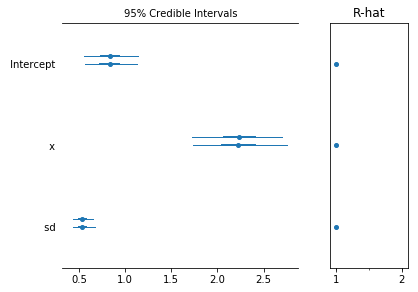

In [44]:
pm.forestplot(glm_samples);

The error distribution, if not specified via the `family` argument, is assumed to be normal. In the case of logistic regression, this can be modified by passing in a `Binomial` family object.

In [45]:
from pymc3.glm.families import Binomial

df_logistic = pd.DataFrame({'x': x, 'y': y > np.median(y)})

with pm.Model() as model_glm_logistic:
    GLM.from_formula('y ~ x', df_logistic, family=Binomial())

## Backends

`PyMC3` has support for different ways to store samples during and after sampling, called backends, including in-memory (default), text file, and SQLite. These can be found in `pymc.backends`:

By default, an in-memory `ndarray` is used but if the samples would get too large to be held in memory we could use the `sqlite` backend:

In [46]:
from pymc3.backends import sqlite

with pm.Model() as model_glm_logistic:
    GLM.from_formula('y ~ x', df_logistic, family=Binomial())
    
    backend = sqlite.SQLite('glm_logistic')
    trace = pm.sample(2000, trace=backend, init=None, nchains=1)

INFO (theano.gof.compilelock): Waiting for existing lock by process '1046' (I am process '1113')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/fonnesbeck/.theano/compiledir_Linux-4.14--g1048e72698de-x86_64-with-debian-9.4--3.6.5-64/lock_dir
Sequential sampling (1 chains in 1 job)
NUTS: [x, Intercept]
  0%|          | 0/2500 [00:00<?, ?it/s]/home/fonnesbeck/Repos/pymc3/pymc3/backends/sqlite.py:121: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(self.var_dtypes[varname], np.int):
100%|██████████| 2500/2500 [00:07<00:00, 348.10it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


The stored trace can then later be loaded using the `load` command:

In [47]:
from pymc3.backends.sqlite import load

with model_glm_logistic:
    trace_loaded = load('glm_logistic')

In [48]:
trace_loaded

<MultiTrace: 1 chains, 2500 iterations, 2 variables>

## References

1. Ching & Chen. 2007. Transitional Markov chain Monte Carlo method for Bayesian model updating, model class selection and model averaging. Journal of Engineering Mechanics 2007
2.	Hoffman MD, Gelman A. 2014. The No-U-turn sampler: adaptively setting path lengths in Hamiltonian Monte Carlo. The Journal of Machine Learning Research. 15(1):1593-1623.
3. M.I. Jordan. 2004. Graphical models. Statist. Sci., 19(1):140–155.
4. Neal, R. M. 2003. Slice sampling. The Annals of Statistics, 31(3), 705–767. doi:10.1111/1467-9868.00198
5. VanderPlas, J. (2014). Frequentism and bayesianism: A python-driven primer. arXiv preprint arXiv:1411.5018.